$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
$$

In [14]:
from __future__ import division
# plotting
%matplotlib inline
from matplotlib import pyplot as plt;
if "bmh" in plt.style.available: plt.style.use("bmh");

# scientific
import numpy as np;
import scipy as scp;
import scipy.stats;

# rise config
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'simple',
              'start_slideshow_at': 'selected',
})

from tabulate import tabulate

import warnings
warnings.simplefilter("ignore")

# EECS 545:  Machine Learning
## Lecture 05:  Linear Regression II
* Instructor:  **Jacob Abernethy**
* Date:  January 25, 2015

*Lecture Exposition Credit: Benjamin Bray and Zhe Du*

## Outline for this Lecture
- Overfitting
- Regularized Least Squares
- Locally-Weighted Linear Regression
- Maximum Likelihood Interpretation of Linear Regression


## Reading List
- Required:    
    - **[PRML]**, §3.2: The Bias-Variance Decomposition
    - **[PRML]**, §3.3: Bayesian Linear Regression
- Optional:
    - **[MLAPP]**, Chapter 7: Linear Regression

> In this lecture, we will first look at how degree of linear regression and sample dataset size will cause *overfitting* in linear regression. To deal with overfitting, *regularized least squares* will be introduced. When predicting the label of a new observation in linear regression, if we want to rely more on nearby traing data than distant training data, we will resort to *locally-weighted linear regression*. Finally, we will show regular linear regression and regularized linear regression can be interpreted from probablistic perspective each using *maximum likelihood estimation* and *maximum a posteriori estimation*.

## Overfitting

### Overfitting: Degree of Linear Regression

(Jake): Maybe more explanation of these plots?

In [2]:
def regression_overfitting_degree(degree0, degree1, degree2, degree3):
    degreelist = np.array([degree0, degree1, degree2, degree3]);
    x = np.linspace(0, 2*np.pi, 13);
    # np.random.randn generates gaussian samples
    y = np.sin(x) + np.random.randn(x.shape[0]) * 0.3; 
    xx = np.linspace(0, 2*np.pi, 100);
    plt.figure(figsize=(12,7.5)) ;
    for i in range(0,4):
        degree = degreelist[i]
        coeffs = np.polyfit(x, y, degree);
        poly = np.poly1d(coeffs);        
        plt.subplot(2,2,i+1);
        plt.plot(xx, np.sin(xx), "g", linestyle='--'); plt.hold(True)
        plt.plot(x, y, "or");
        plt.plot(xx, poly(xx), color='b', linestyle='-'); plt.hold(False)
        plt.legend(['True Curve','Data','Learned Curve']); 
        plt.title(str(degree)+'th Order Polynomial')

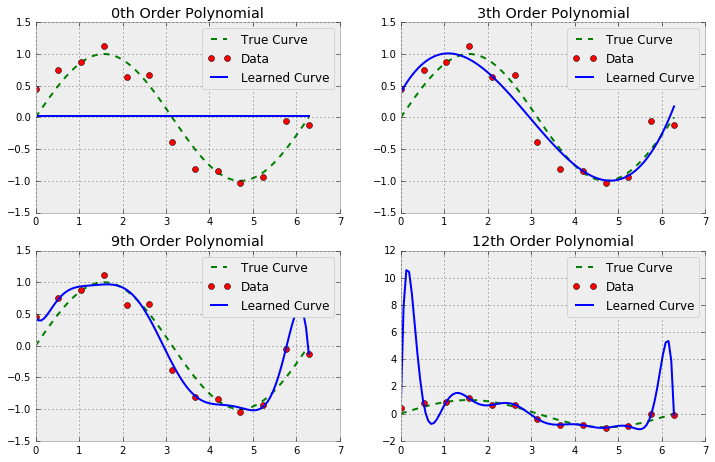

In [3]:
regression_overfitting_degree(degree0=0, degree1=3,degree2=9,degree3=12)

> **Remark**
>    - **Underfitting** occurs in the first plot (degree=0, M=1), which learned curve cannot fit the training data and match true curve.
>    - The second plot (degree=3, M=4) fits the data and true curve perfectly.
>    - **Overfitting** occur in third and fourth plots. As the degree increase, the traning data are fitted better but the learned curve deviates from the true curve further.

### Overfitting: Dataset Size

(Jake): Maybe more explanation of these plots?

In [4]:
def regression_overfitting_datasetsize(size0, size1, size2, size3):
    sizelist = np.array([size0, size1, size2, size3]);
    degree = 12;
    plt.figure(figsize=(12,7.5)) ;
    for i in range(0,4):
        size = sizelist[i]
        x = np.linspace(0, 2*np.pi, size);
        y = np.sin(x) + np.random.randn(x.shape[0]) * 0.3; 
        xx = np.linspace(0, 2*np.pi, 100);
        coeffs = np.polyfit(x, y, degree);
        poly = np.poly1d(coeffs);
        plt.subplot(2,2,i+1);
        plt.plot(xx, np.sin(xx), "g", linestyle='--'); plt.hold(True)
        plt.plot(x, y, "or");
        plt.plot(xx, poly(xx), color='b', linestyle='-'); plt.hold(False)
        plt.legend(['True Curve','Data','Learned Curve']); 
        plt.title('Training Dataset Size = ' + str(size))
        

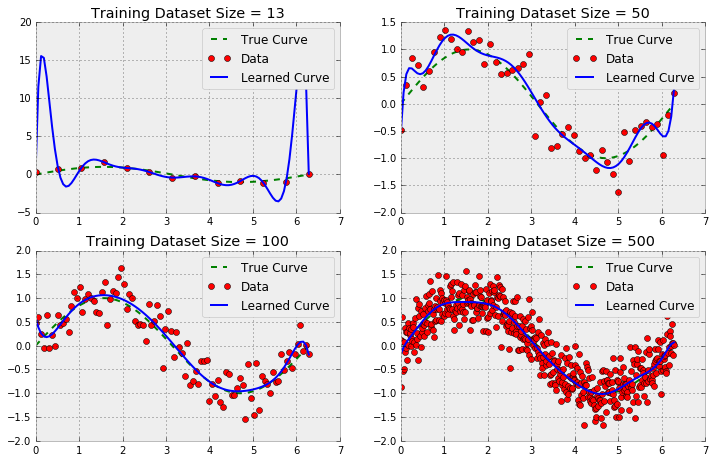

In [5]:
regression_overfitting_datasetsize(size0 = 13, size1 = 50, size2 = 100, size3 = 500)

> **Remark**
>   - We fix the degree to be 12 and vary the training dataset size.
>   - When the degree (12) is large, for small dataset size, overfitting may easily occur. However, as the size increases, the learned curve cannot fit all the training data, but it matches the true curve better and better.

### Overfitting: Overall Performance

* On the left plot, we fix the dataset size and vary the polynomial degree
* On the right plot, we fix the polynomial degree and vary the dataset size

In [6]:
def regression_overfitting_curve():
    #   Plot the training error and test error w.r.t. dataset size
    numItrn = 100
    degreelist = range(0, 14)
    numTrain = 20
    numTest = 50
    dataTrain = np.linspace(0, 2*np.pi, numTrain)
    labelTrain = np.sin(dataTrain) + np.random.randn(dataTrain.shape[0]) * 0.3
    dataTest = np.linspace(0, 2*np.pi, numTest)
    labelTest = np.sin(dataTest) + np.random.randn(dataTest.shape[0]) * 0.3
    errTrain = np.zeros(degreelist.__len__())
    errTest = np.zeros(degreelist.__len__())
    for j in range(0, numItrn):
        for i in range(0, degreelist.__len__()):
            degree = degreelist[i]
            coeffs = np.polyfit(dataTrain, labelTrain, degree)
            poly = np.poly1d(coeffs)
            predTrain = poly(dataTrain)
            predTest = poly(dataTest)
            errTrain[i] += np.sqrt(((predTrain - labelTrain)**2).sum()/numTrain)/numItrn
            errTest[i] += np.sqrt(((predTest - labelTest)**2).sum()/numTest)/numItrn
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(degreelist, errTrain, color='r', linestyle='-', marker='o'); plt.hold(True)
    plt.plot(degreelist, errTest, color='b', linestyle='-', marker='x'); plt.hold(False)
    plt.legend(['Training Error','Test Error'])
    plt.xlabel('Degree of Linear Regression'); plt.ylabel('RMSE');
    plt.title('Training Error and Test Error v.s. Degree')
    #   Plot the training error and test error w.r.t. degree
    sizelist = 10 * np.array(range(1, 16));
    numTest = 50
    degree = 12
    errTrain = np.zeros(sizelist.shape[0])
    errTest = np.zeros(sizelist.shape[0])
    for j in range(0, numItrn):    
        for i in range(0, sizelist.shape[0]):
            numTrain = sizelist[i]
            dataTrain = np.linspace(0, 2*np.pi, numTrain)
            labelTrain = np.sin(dataTrain) + np.random.randn(dataTrain.shape[0]) * 0.3
            dataTest = np.linspace(0, 2*np.pi, numTest)
            labelTest = np.sin(dataTest) + np.random.randn(dataTest.shape[0]) * 0.3
            coeffs = np.polyfit(dataTrain, labelTrain, degree)
            poly = np.poly1d(coeffs)
            predTrain = poly(dataTrain)
            predTest = poly(dataTest)
            errTrain[i] += np.sqrt(((predTrain - labelTrain)**2).sum()/numTrain)/numItrn
            errTest[i] += np.sqrt(((predTest - labelTest)**2).sum()/numTest)/numItrn
    plt.subplot(1,2,2)
    plt.plot(sizelist, errTrain, color='r', linestyle='-', marker='o'); plt.hold(True)
    plt.plot(sizelist, errTest, color='b', linestyle='-', marker='x'); plt.hold(False)
    plt.legend(['Training Error','Test Error'])
    plt.xlabel('Training Dataset Size'); plt.ylabel('RMSE');
    plt.title('Training Error and Test Error v.s. Training Dataset Size')
    

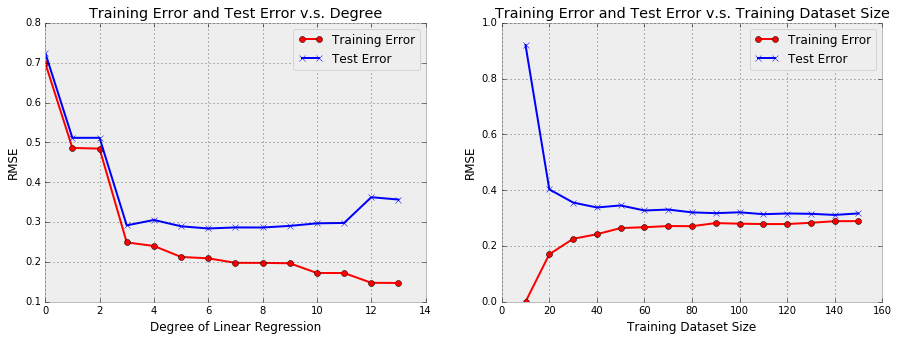

In [7]:
regression_overfitting_curve()

> **Remark**
>   - The plot below is the **root mean squared error (RMSE)** of training dataset and test dataset with respect to different degree and dataset size. 
>   - NOTE: For simplicity of presentation, we divided the dataset into training set and test set. However, it's not legitimate to find the optimal hyperparameter based on the test set. We will talk about legitimate ways of doing this when we cover model selection and cross-validation.
>   - Combining the last 10 plots, we could have:
>   - **Degree**
>       - When degree is really small, the regressor is not powerful enough (i.e. degree is small) to learn the underlying true model. At this time, underfitting occurs. Both training error and test error are high.
>       - As degree increases, regressor become more powerful enough to roughly learn the true model but not that powerful to also take the noise into considerations. At this time, underfitting reduces. Both training error and test error will be smaller. 
>       - As degree further increases, regressor become so powerful that it could fit most of the data in training dataset perfectly. And since the data are noisy, the learned model actually deviates from the true model. At this time, overfitting occurs. Training error could becomes very small (even 0 sometimes), while test error increases. 
>   - **Dataset Size**
>       - When training dataset size is small, a powerful regressor (i.e. degree is high) can fit every single sample in training dataset. Therefore, noise is also considered. This is equivalent to the ending zone of the plot (left) with respect degree.
>       - As training dataset size increases, since the power of regressor is finite (degree is fixed), regressor starts to fail to fit every single sample. Instead it seeks to learn a curve such that samples will fall on both sides equally. Since the noise are assumed to 0 mean Gaussian noise which is symmetric with respect to 0, this is actually close to the underlying true curve.
>       - The training error and test error will converge to 0.3 which is the variance of noise (you could check this by examining the Python code). This is not a coincidence and can be derived. We will cover this later when we study **bias-variance tradeoff**
>   - $$\text{RMSE} = \sqrt{\frac{1}{N} \sum_{n=1}^{N} (y_n-t_n)^2}$$

### Rule of Thumb to Choose the Degree
- For a small number of datapoints, use a low degree
    - Otherwise, the model will overfit!
- As you obtain more data, you can gradually increase the degree
    - Add more features to represent more data
    - **Warning:**  Your model is still limited by the finite amount of data available.  The optimal model for finite data cannot be an infinite-dimensional polynomial!)
- Use **regularization** to control model complexity.

## Regularized Linear Regression

### Coefficients of Overfitting

- Before we move to regularized linear regression, let's first look at what happened to the coefficients $\vec{w}$ when there is overfitting.

In [16]:
# (Jake): The table below doesn't always look very good due to scaling issues.
# Can I recommend you put things into a pandas DataFrame and print these? Looks much better
# Here's an example:
import pandas as pd
pd.DataFrame(
    [
        [1,2,3,4],
        [5,6,7,8],
        [0,0,0,0]
    ],
    columns=["col 1", "col2", "col3","col xyz"],
    index=["a","b","c"]
)

,col 1,col2,col3,col xyz
a,1,2,3,4
b,5,6,7,8
c,0,0,0,0


In [8]:
def regression_overfitting_coeffs():
    degree0 = 0
    degree1 = 3
    degree2 = 9
    degree3 = 12
    degreelist = np.array([degree0, degree1, degree2, degree3])
    x = np.linspace(0, 2*np.pi, degree3+1)
    # np.random.randn generates gaussian samples
    y = np.sin(x) + np.random.randn(x.shape[0]) * 0.3
    y = 100*y
    coeffs = np.zeros([4,degree3+1])
    for i in range(0,4):
        degree = degreelist[i]
        coeffs[i,0:degree+1] = np.polyfit(x, y, degree)
    table = []
    for i in range(0, degree3+1):
        row = ['w_'+str(i)]
        for j in range(0, 4):
            if coeffs[j, i] != 0:
                row.append(coeffs[j, i])
            else:
                row.append(None)
        table.append(row)
    header = ['M='+str(degree0)+' (Underfitting)', 'M='+str(degree1)+' (Good)', 'M='+str(degree2)+' (Overfitting)', 'M='+str(degree3)+' (Overfitting)']
    print tabulate(table, header, tablefmt="rst", floatfmt=".2f")
  

In [9]:
regression_overfitting_coeffs()

====  ====================  ============  ===================  ====================
        M=0 (Underfitting)    M=3 (Good)    M=9 (Overfitting)    M=12 (Overfitting)
====  ====================  ============  ===================  ====================
w_0                  11.74         12.06                 0.09                  0.26
w_1                              -112.55                -2.55                 -9.79
w_2                               248.83                29.39                163.81
w_3                               -37.42              -185.43              -1586.97
w_4                                                    694.43               9849.92
w_5                                                  -1544.23             -40922.16
w_6                                                   1897.01             115440.75
w_7                                                  -1096.18            -219583.79
w_8                                                    276.93             27

> **Remark**
>    - The table above corresponds to the coefficients (multiplied by 100 for better visualization) for different degrees.
>    - We could see that when overfitting occurs, we get some really crazy and large numbers!
>    - So one intuition to handle overfitting is to *penalize* large coefficients.

### Regularized Least Squares: Objective Function

- Recall the objective function we minimizes in last lecture is 
$$
E(\vec{w}) = \frac12 \sum_{n=1}^N \left( \vec{w}^T \phi(\vec{x}_n) - t_n \right)^2
$$

- To penalize the large coefficients, we will add one penalization/regularization term to it and minimize them altogether.
$$
E(\vec{w}) = \underbrace{ \frac12 \sum_{n=1}^N \left( \vec{w}^T \phi(\vec{x}_n) - t_n \right)^2 }_{E_D(\vec{w})}+ \underbrace{\boxed{\frac{\lambda}{2} \left \| \vec{w} \right \|^2}}_{E_W(\vec{w})}
$$
of which $E_D(\vec{w})$ represents the term of sum of squared errors and $E_W(\vec{w})$ is the regularization term.

- $\lambda$ is the regularization coefficient. 
- If $\lambda$ is large, $E_{\vec{W}}(\vec{w})$ will dominate the objective function. As a result we will focus more on minimizing $E_W(\vec{w})$ and the resulting solution $\vec{w}$ tends to have smaller norm and the $E_D(\vec{w})$ term will be larger.

### Regularized Least Squares: Derivation
- Based on what we have derived in last lecture, we could write the objective function as
$$
\begin{align}
E(\vec{w}) 
&= \frac12 \sum_{n=1}^N \left( \vec{w}^T \phi(\vec{x}_n) - t_n \right)^2 + \frac{\lambda}{2} \left \| \vec{w} \right \|^2 \\
&= \frac12 \vec{w}^T \Phi^T \Phi \vec{w} - \vec{t}^T \Phi \vec{w} + \frac12 \vec{t}^T \vec{t} + \frac{\lambda}{2}\vec{w}^T\vec{w}
\end{align}
$$

- The gradient is
$$
\begin{align}
\nabla_\vec{w} E(\vec{w}) 
&= \Phi^T \Phi \vec{w} - \Phi^T \vec{t} + \lambda \vec{w}\\
&= (\Phi^T \Phi + \lambda I)\vec{w} - \Phi^T \vec{t}
\end{align}
$$

- Setting the gradient to 0, we will get the solution
$$
\boxed{ \hat{\vec{w}}=(\Phi^T \Phi + \lambda I)^{-1} \Phi^T \vec{t} }
$$

- In the solution to ordinary least squares which is $\hat{\vec{w} }=(\Phi^T \Phi)^{-1} \Phi^T \vec{t}$, we cannot guarantee $\Phi^T \Phi$ is invertible. But in regularized least squares, if $\lambda > 0$, $\Phi^T \Phi + \lambda I$ is always invertible.

### Regularized Least Squares:  Different Norms
- The $\ell^p$ norm of a vector $\vec{x}$ is defined as
$$
\left \| \vec{x} \right \|_p = (\sum_{j=1}^{M} |x_j|^p)^\frac{1}{p}
$$

- For the regularized least squares above, we used $\ell^2$ norm. We could also use other $\ell^p$ norms for different regularizers and the objective function becomes
$$
E(\vec{w}) = \frac12 \sum_{n=1}^N \left( \vec{w}^T \phi(\vec{x}_n) - t_n \right)^2 + \frac{\lambda}{2} \left \| \vec{w} \right \|_p^p
$$
<center> <img src="images/p-norms.png"  style="width:604px;height:228px;"> </center>
<center><span style="font-size:12px">(Contour of Different p-norms)</span></center>

- **Lasso** regularization ($\ell^1$ regularization) tends to generate sparser solutions than **ridge** regression ($\ell^2$ regularization)
<center> <img src="images/lasso-vs-ridge.png"  style="width:700px;height:450px;"> </center>
<div align="right"><span style="color:gray; font-size:10px">(Image taken from [here](http://gerardnico.com/wiki/data_mining/lasso))</span></div>

> **Remark**
>    - RSS is residual of sum of squares, which is the sum of squared errors $E_D(\vec{w})$ we use.
>    - This plot is to illustrate intuitively why lasso has sparser solution than ridge regression.
>    - Our objective function is 
$$
E(\vec{w}) = \frac12 \sum_{n=1}^N \left( \vec{w}^T \phi(\vec{x}_n) - t_n \right)^2 + \frac{\lambda}{2} \left \| \vec{w} \right \|_p^p
$$
To illustrate, lets look at an *equivalent* constrained problem. (Not exactly equivalent, just for illustration purpose)
$$
\begin{aligned}
& {\text{minimize}} &  & \frac12 \sum_{n=1}^N \left( \vec{w}^T \phi(\vec{x}_n) - t_n \right)^2\\
& \text{subject to} &  & \frac{\lambda}{2} \left \| \vec{w} \right \|_p^p \leq C
\end{aligned}
$$
>    - The objective function $\frac12 \sum_{n=1}^N \left( \vec{w}^T \phi(\vec{x}_n) - t_n \right)^2$ is the red contours in the plots. The optimal solution without the constraint is $\hat{\vec{w}}_{OLS}$, which is just the solution to ordinary least squares. The farther we are away from $\hat{\vec{w}}_{OLS}$ the larger objective function will be.
>    - The feasible area that satisfying the constraint is the cyan area in the plots. The solution must fall in these areas. For lasso, it's a diamond; for ridge regression, it's a circle.
>    - As we increase the value of objective function, the contour will expand. The first time the contour *touch* the feasible cyan area, the touching point would be the optimal solution. This is because our solution should both be as close to $\hat{\vec{w}}_{OLS}$ as possible and fall in the feasible area.
>    - Since lasso has diamond area with four corners, the contours tend to touch the corner first. And since the corner is on the axis where coordinate has at least one zero component, this guarantees the sparsity of solution. On the contrary, the circle area in ridge regression cannot give us this property.

### Regularized Least Squares: Example

In [10]:
def regression_regularization(x, y, xx, degree, lamda):
    Phi_x = np.zeros([x.__len__(), degree+1])
    for i in range(0, degree + 1):
        Phi_x[:, i] = x**i
    coeffs = np.dot(np.dot(np.linalg.inv(np.dot(Phi_x.T,Phi_x) + lamda*np.eye(degree+1)), Phi_x.T), y)
    Phi_xx = np.zeros([xx.__len__(), degree+1])
    for i in range(0, degree + 1):
        Phi_xx[:, i] = xx**i
    prediction_x = np.dot(Phi_x, coeffs)
    prediction_xx = np.dot(Phi_xx, coeffs)
    return prediction_xx, prediction_x, coeffs

def regression_regularization_plot():
    degree = 10
    numData = 13
    x = np.linspace(0, 2*np.pi, numData)
    # np.random.randn generates gaussian samples
    y = np.sin(x) + np.random.randn(x.shape[0]) * 0.4
    xx = np.linspace(0, 2*np.pi, 100)

    plt.figure(figsize=(12,7.5))

    # Plot the Ordinary Least Squares, lambda=0
    plt.subplot(2,2,1)
    prediction_xx, _, _ = regression_regularization(x, y, xx, degree, lamda=0)
    plt.plot(xx, np.sin(xx), "g", linestyle='--'); plt.hold(True)
    plt.plot(x, y, "or")
    plt.plot(xx, prediction_xx, color='b', linestyle='-'); plt.hold(False)
    plt.legend(['True Curve','Data','Learned Curve'])
    plt.title('Ordinary Least Squares (Degree='+str(degree)+')')

    # Plot L2 Regularized Least Squares, lambda=e^1
    plt.subplot(2,2,2)
    prediction_xx, _, _ = regression_regularization(x, y, xx, degree, lamda=np.exp(-1))
    plt.plot(xx, np.sin(xx), "g", linestyle='--'); plt.hold(True)
    plt.plot(x, y, "or")
    plt.plot(xx, prediction_xx, color='b', linestyle='-'); plt.hold(False)
    plt.legend(['True Curve','Data','Learned Curve'])
    plt.title('L2 Regularization (Degree=' + str(degree) + ', $\lambda$=$e^{-1}$' + ')')

    # Plot L2 Regularized Least Squares, lambda=e^40
    plt.subplot(2,2,3)
    prediction_xx, _, _ = regression_regularization(x, y, xx, degree, lamda=np.exp(30))
    plt.plot(xx, np.sin(xx), "g", linestyle='--'); plt.hold(True)
    plt.plot(x, y, "or")
    plt.plot(xx, prediction_xx, color='b', linestyle='-'); plt.hold(False)
    plt.legend(['True Curve','Data','Learned Curve'])
    plt.title('L2 Regularization (Degree=' + str(degree) + ', $\lambda$=$e^{30}$' + ')')

    # Plot the Training Error and Test Error vs. Regularization Coefficient
    plt.subplot(2,2,4)
    lamdalist = np.logspace(-20,30,50, base=np.e)
    numTrain = 15
    numTest = 50
    numItrn = 100
    degree = 10
    errTrain = np.zeros(lamdalist.shape[0])
    errTest = np.zeros(lamdalist.shape[0])
    for j in range(0, numItrn):
        dataTrain = np.linspace(0, 2*np.pi, numTrain)
        labelTrain = np.sin(dataTrain) + np.random.randn(dataTrain.shape[0]) * 0.4
        dataTest = np.linspace(0, 2*np.pi, numTest)
        labelTest = np.sin(dataTest) + np.random.randn(dataTest.shape[0]) * 0.4
        for i in range(0, lamdalist.shape[0]):
            lamda = lamdalist[i]
            predTest, predTrain, _ = regression_regularization(dataTrain, labelTrain, dataTest, degree, lamda)
            errTrain[i] += np.sqrt(((predTrain - labelTrain)**2).sum()/numTrain)/numItrn
            errTest[i] += np.sqrt(((predTest - labelTest)**2).sum()/numTest)/numItrn
    plt.plot(np.log(lamdalist), errTrain, color='r', linestyle='-', marker='o'); plt.hold(True)
    plt.plot(np.log(lamdalist), errTest, color='b', linestyle='-', marker='x'); plt.hold(False)
    plt.legend(['Training Error','Test Error'], loc='lower right')
    plt.xlabel('ln($\lambda$)'); plt.ylabel('RMSE')
    plt.title('Training Error and Test Error v.s. $\lambda$')

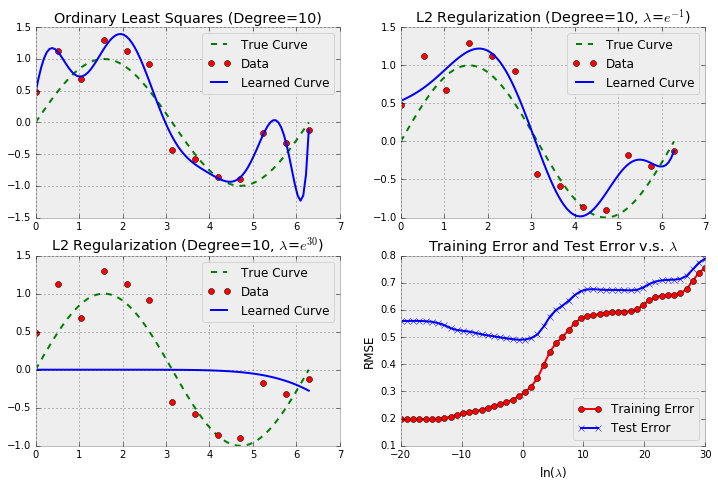

In [11]:
regression_regularization_plot()

(Jake: This remark is great!)
> **Remark**
>    - In the second plot, we can see that after the regularization term is added, the learned curve looks much more like the true curve than the learnd curve without regularization in the first plot.
>    - However, in the third plot, when the coefficient $\lambda$ for regularization is too large, the minimization will mostly focus on minimizing $\left \| \vec{w} \right \|$, thus deviating from the true curve in a great deal. (We will see the coefficients $\vec{w}$) are really small for this case in next slide)
>    - In the fourth plot, as we increase $\lambda$, the training error is monotonically increasing because we are far away from the task of minimizing sum of squared error $E_D(\vec{w})$. As for the the test error, it has minimum value near $\lambda=1$, which is the blancing point in the tradeoff between minimizing $E_D(\vec{w})$ and minimizing regularization term $E_W(\vec{w})$.

### Regularized Least Squares: Coefficients
- Let's look at how the coefficients change after we add regularization

In [12]:
def regression_regularization(x, y, xx, degree, lamda):
    Phi_x = np.zeros([x.__len__(), degree+1])
    for i in range(0, degree + 1):
        Phi_x[:, i] = x**i
    coeffs = np.dot(np.dot(np.linalg.inv(np.dot(Phi_x.T,Phi_x) + lamda*np.eye(degree+1)), Phi_x.T), y)
    Phi_xx = np.zeros([xx.__len__(), degree+1])
    for i in range(0, degree + 1):
        Phi_xx[:, i] = xx**i
    prediction_x = np.dot(Phi_x, coeffs)
    prediction_xx = np.dot(Phi_xx, coeffs)
    return prediction_xx, prediction_x, coeffs

def regression_regularization_coeff():
    lamdalist = np.array([0, np.exp(1), np.exp(10)])
    degree = 10
    x = np.linspace(0, 2*np.pi, degree+1)
    xx = np.linspace(0, 2*np.pi, degree+1)
    y = np.sin(x) + np.random.randn(x.shape[0]) * 0.3
    y = 100*y

    coeffs = np.zeros([4,degree+1])
    for i in range(0,lamdalist.__len__()):
        lamda = lamdalist[i]
        _, _, coeffs[i,0:degree+1] = regression_regularization(x, y, xx, degree, lamda)

    table= []
    for i in range(0, degree+1):
        row = ['w_'+str(i)]
        for j in range(0, lamdalist.__len__()):
            if coeffs[j, i] != 0:
                row.append(coeffs[j, i])
            else:
                row.append(None)
        table.append(row)
    # header = ['M='+str(degree0)+' (Underfitting)', 'M='+str(degree1)+' (Good)', 'M='+str(degree2)+' (Overfitting)', 'M='+str(degree3)+' (Overfitting)']
    header = ['lambda=0', 'lambda=exp^1', 'lambda=exp^10']
    print tabulate(table, header, tablefmt="rst", floatfmt=".2f")

In [13]:
regression_regularization_coeff()

====  ==========  ==============  ===============
        lambda=0    lambda=exp^1    lambda=exp^10
====  ==========  ==============  ===============
w_0         7.75           13.43             0.01
w_1      7995.77           13.71             0.02
w_2    -34162.15           12.36             0.03
w_3     58918.73           10.67             0.04
w_4    -54442.76            6.11             0.05
w_5     30108.85           -2.80             0.06
w_6    -10444.39           -8.55             0.02
w_7      2290.69            5.91            -0.04
w_8      -308.23           -1.53             0.01
w_9        23.21            0.18             0.00
w_10       -0.75           -0.01            -0.00
====  ==========  ==============  ===============


> **Remark**
>    - From the table above, we can see the regularization term has effectively constrained those huge coefficients.
>    - However, when $\lambda$ is large ($\lambda = e^{10}$), the coefficients are "over-regularized".

### Regularized Least Squares:  Summary

- Simple modification of linear regression
- $\ell^2$ Regularization controls the tradeoff between *fitting error* and *complexity*.
    - Small $\ell^2$ regularization results in complex models, but with risk of overfitting
    - Large $\ell^2$ regularization results in simple models, but with risk of underfitting
- It is important to find an optimal regularization that *balances* between the two

## Locally-Weighted Linear Regression

### Locally-Weighted Linear Regression

- **Main Idea:** Given a new observation $\vec{x}$, we generate the coefficients $\vec{w}$ and prediction $y(\vec{x}, \vec{w})$ by giving high weights for *neighbours* of $\vec{x}$.

- ** Regular vs. Locally-Weighted Linear Regression**

**Linear Regression**
<div style="border: 1px solid black; display: block; padding: 15px; margin: 10px 0">
1. Fit $\vec{w}$ to minimize $\sum_{n} (\vec{w}^T \phi(\vec{x}_n) - t_n )^2$ of which $\{(\vec{x}_n, t_n)\}_{n=1}^N$ is the training dataset.
<br>
2. For every new observation $\vec{x}$ to be predicted, output $\vec{w}^T \phi(x)$
<br>
**Note**: **One** $\vec{w}$ for **all** observations to be predicted.
</div>

**Locally-weighted Linear Regression**
<div style="border: 1px solid black; display: block; padding: 15px; margin: 10px 0">
1. For **every** new observation $\vec{x}$ to be predicted, generate the weights $r_n$ for every training sample $(\vec{x}_n, t_n)$. (The closer $\vec{x}_n$ is to $\vec{x}$, the larger $r_n$ will be)
<br>
2. Fit $\vec{w}$ to minimize $\sum_{n} r_n (\vec{w}^T \phi(\vec{x}_n) - t_n )^2$ of which $\{(\vec{x}_n, t_n)\}_{n=1}^N$ is the training dataset.
<br>
3. Output $\vec{w}^T \phi(x)$
<br>
**Note**: **One** $\vec{w}$ for **only one** observations to be predicted.
</div>

### Regular vs. Locally-Weighted Linear Regression

<center><img src="images/lwlr-comparison.png"></center>

- For linear regression with **degree=1**, the learned curve for regular linear regression is a **straight line** while the learned curve for locally-weighted linear regression is a **curve**. For queries/observations with different features (x-axis value), the weights $\vec{r}$ are different thus the solution $\hat{\vec{w}}$ are also different. For 1-degree regression, $\hat{\vec{w}}$ correspond to the interception and slope of learned curve, so the slope for locally-weighted linear regression is always changing and what we get cannot be a straight line.

### Locally-Weighted Linear Regression: Weights

- The standard choice for weights $\vec{r}$ uses the **Gaussian Kernel**, with **kernel width** $\tau$
    $$
    r_n = \exp\left( -\frac{|| \vec{x}_n - \vec{x} ||^2}{2\tau^2} \right)
    $$

- Choice of kernel width matters.
<center> <img src="images/lwlr-kernel-width.png"  style="width:604px;height:228px;"> </center>
- The bell shape is the weight curve, which has maximum at the query point $\vec{x}$ and decreases as we move farther.
- The best kernel includes as many training points as can be accomodated by the model.  Too large a kernel includes points that degrade the fit; too small a kernel neglects points that increase confidence in the fit.

> **Remark**
>    - Note weight $\vec{r}$ and resulting $\hat{\vec{w}}$ depend on $\vec{x}$ (query point); we must solve linear regression for each query point $\vec{x}$.
>    - Can be reformulated as a modified version of least squares problem.
>    - The best kernel width requires hyperparameter tuning

### Locally-Weighted Linear Regression: Derivation
- Recall that in regular linear regression, we have
    $$E(\vec{w}) = \sum_{n=1}^N \left( \vec{w}^T \phi(\vec{x}_n) - t_n \right)^2 = \left \| \Phi \vec{w}-\vec{t} \right \|^2$$

- In locally-weighted linear regression, we are to minimize
    $$E(\vec{w}) = \sum_{n=1}^{N} r_n (\vec{w}^T \phi(\vec{x}_n) - t_n )^2 = \sum_{n=1}^{N} (\sqrt{r_n} \vec{w}^T \phi(\vec{x}_n) - \sqrt{r_n} t_n )^2 = \left \| \sqrt{R} \Phi \vec{w}- \sqrt{R} \vec{t} \right \|^2 $$
    of which 
    $$R = \begin{bmatrix}
    r_1 &  &  & \\ 
     & r_2 &  & \\ 
     &  & \ddots  & \\ 
     &  &  & r_N
    \end{bmatrix}
    $$
    
- The solution to $\ \arg \min \left \| \Phi \vec{w}-\vec{t} \right \|^2 \ $  is $\ \Phi^\dagger \vec{t} \ $. Similarly, the solution to $\ \arg \min \left \| \sqrt{R} \Phi \vec{w}- \sqrt{R} \vec{t} \right \|^2 \ $ is 
    $$
    \boxed{\hat{\vec{w}} = (\sqrt{R} \Phi)^\dagger \sqrt{R} \vec{t}}
    $$

> ** Remark **
>    - We omitted $\frac12$ in the above $E(\vec{w})$ because it will not affect the solution $\vec{w}$. We add $\frac12$ in last lecture because it can cancel out the coefficient 2 generated by differentiating the quadratic expression.

## Probablistic Interpretation of Least Squares Regression
- We have showed derived the solution to least squares regression by minimizing objective function. Now we will provide a probablistic perspective. Specifically, we will show the solution to **regular least squares** is just the **maximum likelihood** estimate of $\vec{w}$ and the solution to **regularized least squares** is the **Maximum a Posteriori** estimate. 

### Some Background
- Gaussian Distribution
$$ 
\mathcal{N}(x, \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left[ \frac{(x-\mu)^2}{2\sigma^2} \right]
$$

- **Maximum Likelihood Estimation** and **Maximum a Posteriori Estimation (MAP)**
    - For distribution $t \sim p(t|\theta)$. $\theta$ is some unknown parameter (like mean or variance) to be estimated.
    - Given observation $\vec{t} = (t_1, t_2, \dots, t_N)$, 
        - The Maximum Likelihood Estimator is
        $$
        \theta_{ML} = \arg \max \prod_{n=1}^N p(t_n | \theta)
        $$
        - If we have some prior knowledge about $\theta$, the MAP estimator is 
        $$
        \theta_{MAP} = \arg \max \prod_{n=1}^N p(\theta | t_n) \quad (\text{Posteriori Probability of } \theta)
        $$        

### Maximum Likelihood Estimator $\vec{w}_{ML}$

- We assume the **signal+noise** model of single data $(\vec{x}, t)$ is
    $$
    \begin{gather}
    t = \vec{w}^T \phi(\vec{x}) + \epsilon \\ 
    \epsilon \sim \mathcal{N}(0, \beta^{-1})
    \end{gather}
    $$
    of which $\vec{w}^T \phi(\vec{x})$ is the true model, $\epsilon$ is the perturbation/randomness.

- Since $\vec{w}^T \phi(\vec{x})$ is deterministic/non-random, we have
    $$
    t \sim \mathcal{N}(\vec{w}^T \phi(\vec{x}), \beta^{-1})
    $$
    
- The **likelihood function** of $t$ is just **probability density function (PDF)** of $t$
    $$
    p(t|x,\vec{w},\beta) = \mathcal{N}(t|\vec{w}^T \phi(\vec{x}),\beta^{-1})
    $$
    
- For inputs $X=(\vec{x}_1, \dots, \vec{x}_n)$ and target values $\vec{t}=(t_1,\dots,t_n)$, the data likelihood is
    $$
    p(\vec{t}|X,\vec{w},\beta)
    = \prod_{n=1}^N p(t_n|\vec{x}_n,\vec{w},\beta)
    = \prod_{n=1}^N \mathcal{N}(t_n|\vec{w}^T\phi(\vec{x}_n),\beta^{-1})
    $$
    
- **Notation Clarification** 
    - $p(t|x,w,\beta)$ it the PDF of $t$ whose distribution is parameterized by $x,\vec{w},\beta$. 
    - $\mathcal{N}(\vec{w}^T \phi(\vec{x}), \beta^{-1})$ is Gaussian distribution with **mean** $\vec{w}^T \phi(\vec{x})$ and **variance** $\beta^{-1}$.
    - $\mathcal{N}(t|\vec{w}^T \phi(\vec{x}),\beta^{-1})$ is the PDF of $\vec{t}$ which has Gaussian distribution $\mathcal{N}(\vec{w}^T \phi(\vec{x}), \beta^{-1})$

### Maximum Likelihood Estimator $\vec{w}_{ML}$
- **Main Idea of Maximum Likelihood Estimate** 
    - Given $\{ \vec(x)_n, t_n \}_{n=1}^N$, we want to find $\vec{w}_{ML}$ that maximizes data likelihood function
        $$
        \vec{w}_{ML}
        =\arg \max p(\vec{t}|X,\vec{w},\beta)
        =\arg \max \prod_{n=1}^N \mathcal{N}(t_n|\vec{w}^T\phi(\vec{x}_n),\beta^{-1})
        $$
        and by derivation we will show $\vec{w}_{ML}$ is equivalent to the least squares solution $\hat{\vec{w}} = \Phi^\dagger \vec{t}$.

- **Intuition about Maximum Likelihood Estimation**
    - Finding maximum likelihood estimate $\vec{w}_{ML} = \arg \max p(\vec{t}|X,\vec{w},\beta)$ is just finding the parameter $\vec{w}$ under which for data $X=(\vec{x}_1, \dots, \vec{x}_n)$, observed $\vec{t}=(t_1,\dots,t_n)$ is the most likely result to be generated among all possible $\vec{t}$.

### Maximum Likelihood Estimator $\vec{w}_{ML}$: Derivation
(Jake: This slide is a little large)
- Single data likelihood is
    $$
    p(t_n|\vec{x}_n,\vec{w},\beta) 
    = \mathcal{N}(t_n|\vec{w}^T\phi(\vec{x}_n),\beta^{-1})
    = \frac{1}{\sqrt{2 \pi \beta^{-1}}} \exp \left \{ - \frac{1}{2 \beta^{-1}} (t_n - \vec{w}^T \phi(x_n))^2 \right \}
    $$

- Single data log-likelihood is 
    $$
    \ln p(t_n|\vec{x}_n,\vec{w},\beta) = - \frac12 \ln 2 \pi \beta^{-1} - \frac{\beta}{2} (\vec{w}^T \phi(x_n) - t_n)^2
    $$
    We do the logarithm because the maximizer of function $f(x)$ is the same as $\log f(x)$. And logarithm can convert product to summation which makes life easier.

- Complete data log-likelohood is
    $$
    \begin{align}
    \ln p(\vec{t}|X,\vec{w},\beta) 
    &= \ln \left[ \prod_{n=1}^N p(t_n|\vec{x}_n,\vec{w},\beta) \right] \\
    &= \sum_{n=1}^N \ln p(t_n|\vec{x}_n,\vec{w},\beta) \\
    &= \sum_{n=1}^N \left[ - \frac12 \ln 2 \pi \beta^{-1} - \frac{\beta}{2} (\vec{w}^T \phi(x_n) - t_n)^2 \right]
    \end{align}
    $$


- Maximum likelihood estimate $\vec{w}_{ML}$ is
    $$
    \begin{align}
    \vec{w}_{ML} 
    &= \underset{\vec{w}}{\arg \max} \ln p(\vec{t}|X,\vec{w},\beta) \\
    &= \underset{\vec{w}}{\arg \max}  \sum_{n=1}^N \left[ - \frac12 \ln 2 \pi \beta^{-1} - \frac{\beta}{2} (\vec{w}^T \phi(x_n) - t_n)^2 \right] \\
    &= \underset{\vec{w}}{\arg \max}  \sum_{n=1}^N \left[ - \frac{\beta}{2} (\vec{w}^T \phi(x_n) - t_n)^2 \right] \\
    &= \underset{\vec{w}}{\arg \min}  \sum_{n=1}^N \left[(\vec{w}^T \phi(x_n) - t_n)^2 \right]
    \end{align}
    $$

- Familiar? Recall the objective function we minimized in least squares is $E(\vec{w}) = \frac12 \sum_{n=1}^N \left( \vec{w}^T \phi(\vec{x}_n) - t_n \right)^2$, so we could conclude that
    $$
    \boxed{\vec{w}_{ML}  = \hat{\vec{w}}_{LS} = \Phi^\dagger \vec{t}}
    $$

### MAP Estimator $\vec{w}_{MAP}$
- The **MAP estimator** is obtained by
    $$
    \begin{align}
        \vec{w}_{MAP} 
    &= \arg \max p(\vec{w}|\vec{t}, X,\beta) & & (\text{Posteriori Probability})\\
    &= \arg \max \frac{p(\vec{w}, \vec{t}, X,\beta)}{p(X, t, \beta)} \\
    &= \arg \max \frac{p(\vec{t}|\vec{w}, X,\beta) p(\vec{w}, X, \beta)}{p(X, t, \beta)} \\
    &= \arg \max p(\vec{t}|\vec{w}, X,\beta) p(\vec{w}, X, \beta) & & (p(X, t, \beta) \text{ is irrelevant to} \ \vec{w})\\
    &= \arg \max p(\vec{t}|\vec{w}, X,\beta) p(\vec{w}) p(X) p(\beta) & & (\text{Independence}) \\
    &= \arg \max p(\vec{t}|\vec{w}, X,\beta) p(\vec{w}) & & (\text{Likelihood} \times \text{Prior})
    \end{align}
    $$
    We are just using **Bayes Theorem** for the above steps.
- The only difference from ML estimator is we have an extra term of PDF of $\vec{w}$. This is the **prior belief** of $\vec{w}$. Here, we assume, 
    $$
    \vec{w} \sim \mathcal{N}(\vec{0}, \lambda^{-1}I) 
    $$

- ML vs. MAP
    - Maximum Likelihood: We know **nothing** about $\vec{w}$ initially and every $\vec{w}$ are equally likelihood
    - Maximum a Posteriori: We know **something** about about $\vec{w}$ initially and certain $\vec{w}$ are more likely (depending on **prior** $p(\vec{w})$). In another way, $\vec{w}$ are weighted.
- Assumption $\vec{w} \sim \mathcal{N}(\vec{0}, \lambda^{-1}I)$ makes sense because
    - In **regularized least squares**
        - We already know large coefficient $\vec{w}$ that may lead to overfitting should be avoided. 
        - When we increase $\lambda$, the smaller $\left \| \vec{w} \right \|$ will be.
            - *Exercise*: Why?
    - For $\vec{w} \sim \mathcal{N}(\vec{0}, \lambda^{-1}I)$
        - $\vec{w} \sim \mathcal{N}(\vec{0}, \lambda^{-1}I)$ encodes the assumption that $\vec{w}$ with a smaller norm $\left \| \vec{w} \right \|$ is more "likely" than a $\vec{w}$ with a bigger norm.
        - When we increase $\lambda$, variance is smaller, small $\left \| \vec{w} \right \|$ will be much more likely
        

### MAP Estimator $\vec{w}_{MAP}$: Derivation
- $\vec{w} \sim \mathcal{N}(\vec{0}, \lambda^{-1}I)$ is **multivariate Gaussian** which has PDF
    $$
    p(\vec{w}) = \frac{1}{\left( \sqrt{2 \pi \lambda^{-1}} \right)^N} \exp \left \{ -\frac{1}{2 \lambda^{-1}} \sum_{n=1}^N w_n^2 \right \}
    $$

- So the MAP estimator is 
    $$
    \begin{align}
     \vec{w}_{MAP} 
     &= \underset{\vec{w}}{\arg \max} p(\vec{t}|\vec{w}, X,\beta) p(\vec{w}) \\
     &= \underset{\vec{w}}{\arg \max} \left[\ln p(\vec{t}|\vec{w}, X,\beta) + \ln p(\vec{w}) \right] \\
     &= \underset{\vec{w}}{\arg \min} \left[ \sum_{n=1}^N (\vec{w}^T \phi(x_n) - t_n)^2  +  \frac{\lambda}{2} \sum_{n=1}^N w_n^2 \right] \\
     &= \underset{\vec{w}}{\arg \min} \left[ \sum_{n=1}^N (\vec{w}^T \phi(x_n) - t_n)^2  +  \frac{\lambda}{2} \left \| \vec{w} \right \|^2 \right]
    \end{align}
    $$
    
- Exactly the objective in regularized least squares! So
$$
\boxed{ \vec{w}_{MAP} = \hat{\vec{w}}=(\Phi^T \Phi + \lambda I)^{-1} \Phi^T \vec{t} }
$$
 

> ** Remark **
>    - **Priors**: Represent prior beliefs about acceptable values for model parameters.
>    - Example: In linear regression, L2 regularization can be interpreted as placing a Gaussian Prior on the regression coefficients.
>    - All statistical models and machine learning algorithms make assumptions.
>        - All reasoning is based on implicit assumptions.
>        - A Bayesian will tell you that his prior is a way of explicitly stating those assumptions.
>    - This can all get very philosophical, but...
>        - Bayesian reasoning is best seen as a useful tool.
>        - Many concepts in machine learning have Bayesian interpretations. 
>            - Choice of loss / error function, regularization, etc.
>    - For a fully Bayesian take on machine learning, check out the **Murphy** textbook:
<center> <img src="images/murphy.jpg"  style="width:180px;height:228px;"> </center>
>    - We will cover more about Bayesian reasoning when we move to **Bayesian Linear Regression**, a linear regression that is used for streaming data.